 # Project Overview

This capstone project implements a data-driven system to optimize inventory management. It replaces static, rule-based reordering policies with a dynamic, predictive engine that forecasts future demand and calculates the optimal Reorder Point (ROP) and Reorder Quantity (ROQ) for each product.

The goal is to minimize total inventory costs by balancing the reduction of costly stockouts (lost sales) against the minimization of expensive holding costs (storage, capital tied up).

# 1. Import Libraries

In [46]:
# Install Statsmodels
#! pip install statsmodels

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR



# 2. Load Data

In [72]:
data = pd.read_csv('retail_store_inventory.csv')
data.head()


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [73]:
#check the columns and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

- No missing values in my data

In [74]:
data.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

# 3. Data Preparation and Feature Engineering

In [75]:
# Convert 'Date' to datetime and create 'SKU_Compound_ID'
data['Date'] = pd.to_datetime(data['Date'])
data['SKU_Compound_ID'] = data['Store ID'] + '_'+ data['Product ID']

In [76]:
data.sort_values(by = ['SKU_Compound_ID', 'Date'], inplace=True)

In [77]:
# Define a helper function to shift the series before calculating rolling features
# This prevents data leakage by ensuring that the rolling calculations do not include the current day's data
def create_rolling_feature(series, window, func):
        return series.shift(1).rolling(window=window).apply(func, raw=True)

In [78]:
# Lagged Demand 
data['demand_lag_7'] = data.groupby('SKU_Compound_ID')['Units Sold'].shift(7)
data['demand_lag_14'] = data.groupby('SKU_Compound_ID')['Units Sold'].shift(14)
data['demand_lag_30'] = data.groupby('SKU_Compound_ID')['Units Sold'].shift(30)
data['demand_lag_90'] = data.groupby('SKU_Compound_ID')['Units Sold'].shift(90)

Create rolling (moving) window statistics for each SKU(Stock Keeping Unit) over time like average units sold over the past 14 and 30 days or the variability of sales over the past 30 days.

- We have mean [ this is the average units sold over the last 14. 30 days] and Standard deviation[measures how much sales fluctutate in the past time lags].

- Standard deviation will give us the sales volatility while mean will give us the recent sales Trends.

- 30 day rolling mean will give us a smoother long term trend compared to 14 day.

- Each new day, the rolling mean and standard deviation update based on the last 14 or 30 records for that particular SKU.

In [79]:
# Rolling Mean and Standard Deviation
data['RollingMean_14'] = create_rolling_feature(data.groupby('SKU_Compound_ID')['Units Sold'], 14, np.mean)
data['RollingStd_14'] = create_rolling_feature(data.groupby('SKU_Compound_ID')['Units Sold'], 14, np.std)

data['RollingMean_30'] = create_rolling_feature(data.groupby('SKU_Compound_ID')['Units Sold'], 30, np.mean)
data['RollingStd_30'] = create_rolling_feature(data.groupby('SKU_Compound_ID')['Units Sold'], 30, np.std)

In [80]:
# display the rolling features
data[['SKU_Compound_ID', 'Date', 'Units Sold', 'RollingMean_14', 'RollingStd_14', 'RollingMean_30', 'RollingStd_30']].head(20)  
data.tail()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,Seasonality,SKU_Compound_ID,demand_lag_7,demand_lag_14,demand_lag_30,demand_lag_90,RollingMean_14,RollingStd_14,RollingMean_30,RollingStd_30
72699,2023-12-28,S005,P0020,Groceries,South,198,56,27,50.18,21.75,...,Winter,S005_P0020,160.0,80.0,28.0,321.0,137.214286,85.748118,147.533333,113.239491
72799,2023-12-29,S005,P0020,Clothing,East,446,268,30,267.54,85.58,...,Summer,S005_P0020,228.0,280.0,183.0,241.0,135.500000,87.104002,148.466667,112.362429
72899,2023-12-30,S005,P0020,Toys,North,251,149,181,162.92,79.48,...,Autumn,S005_P0020,220.0,3.0,219.0,60.0,134.642857,85.725981,151.300000,114.253271
72999,2023-12-31,S005,P0020,Furniture,East,64,40,99,59.69,90.79,...,Winter,S005_P0020,6.0,165.0,151.0,87.0,145.071429,77.569751,148.966667,113.559524
73099,2024-01-01,S005,P0020,Groceries,East,117,6,165,2.33,78.39,...,Spring,S005_P0020,31.0,113.0,170.0,18.0,136.142857,81.838567,145.266667,115.229028


In [81]:
# Time based Features
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['DayOfMonth'] = data['Date'].dt.day    
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Year'] = data['Date'].dt.year

Logistics and Inventory Management parameters
1. Lead time - How long it takes from placing an order with the supplier until the goods arrive.
2. Holding (carrying) cost - Rep the expense of keeping inventory in storage. This includes warehouse, depreciation, insurance and opportunity cost of capital
3. Ordering Cost - the fixed cost of placing one order, regardless of quantity. This includes administrative work, shipping, handling, and setup.
4. Service Level - is the probability of not running out of stock during the lead time.
5. Z-score (from the normal distribution) helps calculate safety stock. 

      Safety Stock = Z x std demand x square root of Lead time

  So, a Z = 1.645 gives a 95% confidence that demand during lead time will be covered.

In [82]:
# Inventory Data or Parameters for Reorder System
data['Lead_Time_Days'] = 7  # assuming a fixed lead time of 7 days for all products
data['Holding_Cost_H'] = 0.05  # assuming a fixed holding cost per unit per day
data['Ordering_Cost_S'] = 20  # assuming a fixed ordering cost per order
data['Service_Level_Z'] = 0.95  # assuming a target service level of 95%

### Encoding

In [83]:
# Use Label Encoding for 'SKU_Compound_ID'
le = LabelEncoder()
data['SKU_Compound_ID_Encoded'] = le.fit_transform(data['SKU_Compound_ID']) 

In [84]:
# check for the categorical variables
data.select_dtypes(include=['object']).columns



Index(['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition',
       'Seasonality', 'SKU_Compound_ID'],
      dtype='object')

In [85]:
# One Hot Encoding for other categorical variables
data = pd.get_dummies(data, columns=['Category', 'Region', 'Weather Condition', 'Seasonality'], drop_first=True)

In [86]:
#data.info()# Drop the NaN values resulted from lagged and rolling features
data.dropna(inplace=True)

In [87]:
data.head()

,Date,Store ID,Product ID,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,...,Category_Toys,Region_North,Region_South,Region_West,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
9000,2022-04-01,S001,P0001,215,101,65,102.74,44.62,0,1,...,False,False,False,True,False,False,False,False,True,False
9100,2022-04-02,S001,P0001,200,70,54,74.21,81.11,15,1,...,False,False,False,False,False,False,True,False,False,True
9200,2022-04-03,S001,P0001,208,32,142,42.34,51.04,15,0,...,True,False,True,False,False,True,False,False,True,False
9300,2022-04-04,S001,P0001,70,54,197,60.25,70.04,10,1,...,False,True,False,False,False,False,True,False,True,False
9400,2022-04-05,S001,P0001,309,165,105,176.64,90.24,10,0,...,False,False,False,False,False,True,False,False,False,True


# 3. DEMAND FORECASTING ENGINE

3.1  Define Target and split Date

In [88]:
# check all columns 
data.columns


Index(['Date', 'Store ID', 'Product ID', 'Inventory Level', 'Units Sold',
       'Units Ordered', 'Demand Forecast', 'Price', 'Discount',
       'Holiday/Promotion', 'Competitor Pricing', 'SKU_Compound_ID',
       'demand_lag_7', 'demand_lag_14', 'demand_lag_30', 'demand_lag_90',
       'RollingMean_14', 'RollingStd_14', 'RollingMean_30', 'RollingStd_30',
       'DayOfWeek', 'DayOfMonth', 'Month', 'Quarter', 'Year', 'Lead_Time_Days',
       'Holding_Cost_H', 'Ordering_Cost_S', 'Service_Level_Z',
       'SKU_Compound_ID_Encoded', 'Category_Electronics', 'Category_Furniture',
       'Category_Groceries', 'Category_Toys', 'Region_North', 'Region_South',
       'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter'],
      dtype='object')

In [90]:
TARGET = 'Units Sold'

# Columns to ignore (non-predictive or not needed for training)
IGNORE_COLS = [
    'Date', 'Store ID', 'Product ID', 'SKU_Compound_ID',
    'Units Ordered', 'Demand Forecast',
    'Lead_Time_Days', 'Holding_Cost_H', 'Ordering_Cost_S', 'Service_Level_Z'
]

# Select all feature columns that are not ignored and not the target
FEATURES = [col for col in data.columns if col not in IGNORE_COLS and col != TARGET]

# Sort data by date before splitting
data = data.sort_values('Date').reset_index(drop=True)

# Time based split: Use 90% for training, 10% for testing
split_date = data['Date'].quantile(0.9)

#Split the data  into training (past) and testing (future) subsets.
train_data = data[data['Date'] <= split_date]
test_data = data[data['Date'] > split_date]

# Redefine X and y for train and test sets based on the time split
X_train, y_train  = train_data[FEATURES], train_data[TARGET]
X_test, y_test = test_data[FEATURES], test_data[TARGET]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Training Period Ends: {split_date.date()}")

# --- IGNORE ---


Training samples: 57700, Testing samples: 6400
Training Period Ends: 2023-10-29


# INSIGHTS
- In forecasting or time- series problems, random splitting (like in normal regression) would leak future information into the training set.

- Now by splitting chronologically, the model learns from the past, predicts the future and gets evaluated realistically(like how it would perform in production)

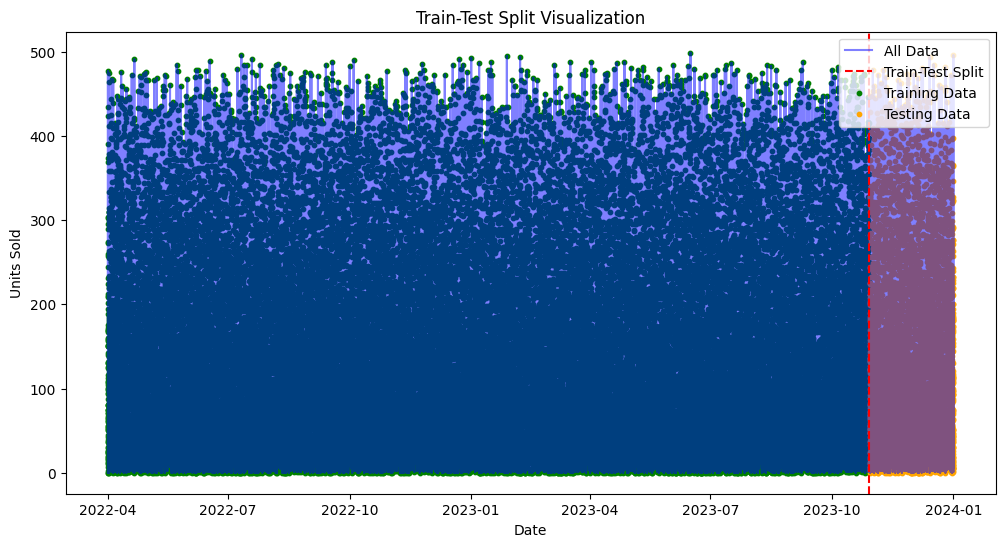

In [93]:
# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Units Sold'], label='All Data', color='blue', alpha=0.5)
plt.axvline(x=split_date, color='red', linestyle='--', label='Train-Test Split')
plt.scatter(train_data['Date'], train_data['Units Sold'], color='green', label='Training Data', s=10)
plt.scatter(test_data['Date'], test_data['Units Sold'], color='orange', label='Testing Data', s=10)
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Train-Test Split Visualization')
plt.legend()
plt.show()